# Test

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [12]:
from learn import *
sys.path.insert(0, 'code')
from v17 import *
from v17 import _internal_validate_predict_best_param
sys.path.insert(0, 'Pytorch-UNet/utils')
from crf import dense_crf

In [13]:
sz = 256
num_slice = 9

num_gpus = 2
gpu_start = 4
num_workers = 8
device_ids = range(gpu_start, gpu_start + num_gpus)
# device_ids = [4,5,8,9]
torch.cuda.set_device(gpu_start)
bs = 8

model_name = 'deeplab'
datapaths = ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']
datapath = datapaths[0]

## Preprocessing

In [14]:
# !python code/v5_im-full_rgb.py preproc_test {datapaths[0]}

In [15]:
# !python code/v5_im-full_rgb.py preproc_test {datapaths[3]}

In [16]:
# !python code/v5_im-full_rgb.py preproc_test {datapaths[0]}
# !python code/v5_im-full_rgb.py preproc_test {datapaths[2]}

## Scripting

In [2]:
%%time
%run test 0 --gpu_start=6 --num_gpus=2 --bs=8 --pred


Data finished loading: data/train/AOI_2_Vegas_Train
CPU times: user 2h 41min 20s, sys: 14min 6s, total: 2h 55min 26s
Wall time: 5min 52s


## Polygon best threshold

In [3]:
def evalfscore_thresh(thresh):
    return evalfscore(datapath, preds, thresh=thresh)

In [ ]:
%%time
threshs = np.linspace(0, 1, 21)
polygon_pr = []
for thresh in threshs:
#     with ThreadPoolExecutor(max_workers=8) as e:
    s = evalfscore_thresh(thresh)
    print(s)
    polygon_pr.append(s)
# plt.plot(polygon_pr)

(0.000237, 0.00346, 0.000123)
(0.374901, 0.468579, 0.312439)
(0.594928, 0.689548, 0.523142)
(0.690525, 0.767604, 0.627513)
(0.74253, 0.819116, 0.67904)
(0.766841, 0.841313, 0.704481)
(0.782499, 0.862251, 0.716252)
(0.791453, 0.874768, 0.722628)
(0.791875, 0.876162, 0.722382)
(0.790806, 0.876571, 0.720329)
(0.785269, 0.871774, 0.714382)
(0.778232, 0.866353, 0.706382)
(0.767588, 0.856905, 0.695132)
(0.753439, 0.843402, 0.680818)
(0.736762, 0.828068, 0.663591)
(0.711248, 0.801661, 0.639161)
(0.676087, 0.765002, 0.605689)
(0.619106, 0.704209, 0.552354)
(0.515396, 0.592817, 0.455861)


## evalfscore

In [17]:
model_name = 'deeplab'
data = None
is_eval, is_pred = True, False

In [18]:
learn, denorm, data = learner_on_dataset(datapath, bs, device_ids, num_workers, model_name='deeplab',
                                         debug=False, data=data, num_slice=num_slice, sz=sz,
                                        is_eval=is_eval, is_pred=is_pred)
(trn_x,trn_y), (val_x,val_y) = data
learn.load('deeplab-vegas')


Data finished loading: data/train/AOI_2_Vegas_Train


In [19]:
%%time
preds = learn.predict().squeeze()

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/THCTensorCopy.cu:204

In [20]:
%%time
evalfscore(datapath, preds)

NameError: name 'preds' is not defined

In [11]:
%%time
with ThreadPoolExecutor(max_workers=8) as e:
    x, y = list(zip(*list(e.map(learn.data.val_dl.get_batch, [[o] for o in range(preds.shape[0])]))))
x, y, preds = [np.squeeze(o) for o in (x, y, preds)]
print(preds.shape)

(10404, 256, 256)
CPU times: user 2min 43s, sys: 48.7 s, total: 3min 32s
Wall time: 33.9 s


In [ ]:
scores = None

In [ ]:
scores, idx = plot_worse_preds(x, y, preds, learn, jaccard_coef, shift=600,
                          scores=scores, is_best=0, thresh=0.5)

## testproc

In [5]:
data = None
is_eval, is_pred = False, True

In [6]:
learn, denorm, data = learner_on_dataset(datapath, bs, device_ids, num_workers, model_name='deeplab',
                                         debug=False, data=data, num_slice=num_slice, sz=sz,
                                        is_eval=is_eval, is_pred=is_pred)
(trn_x,trn_y), (val_x,val_y) = data
learn.load('deeplab-vegas')

Data finished loading: data/train/AOI_2_Vegas_Train


In [ ]:
%%time
preds = learn.predict().squeeze()

In [ ]:
%%time
testproc(datapath, preds)

## Plot images after putting back

In [ ]:
fn_train = FMT_VALTEST_IMAGELIST_PATH.format(prefix='AOI_2_Vegas')
df_train = pd.read_csv(fn_train)

In [ ]:
df_train[df_train.ImageId == 'AOI_2_Vegas_img485']

In [12]:
preds_big = _internal_validate_predict_best_param(3, slice_pred_list=[preds])
x_big = _internal_validate_predict_best_param(3, slice_pred_list=[denorm(x)])
y_big = _internal_validate_predict_best_param(3, slice_pred_list=[y])
x_big[0].shape

(650, 650, 3)

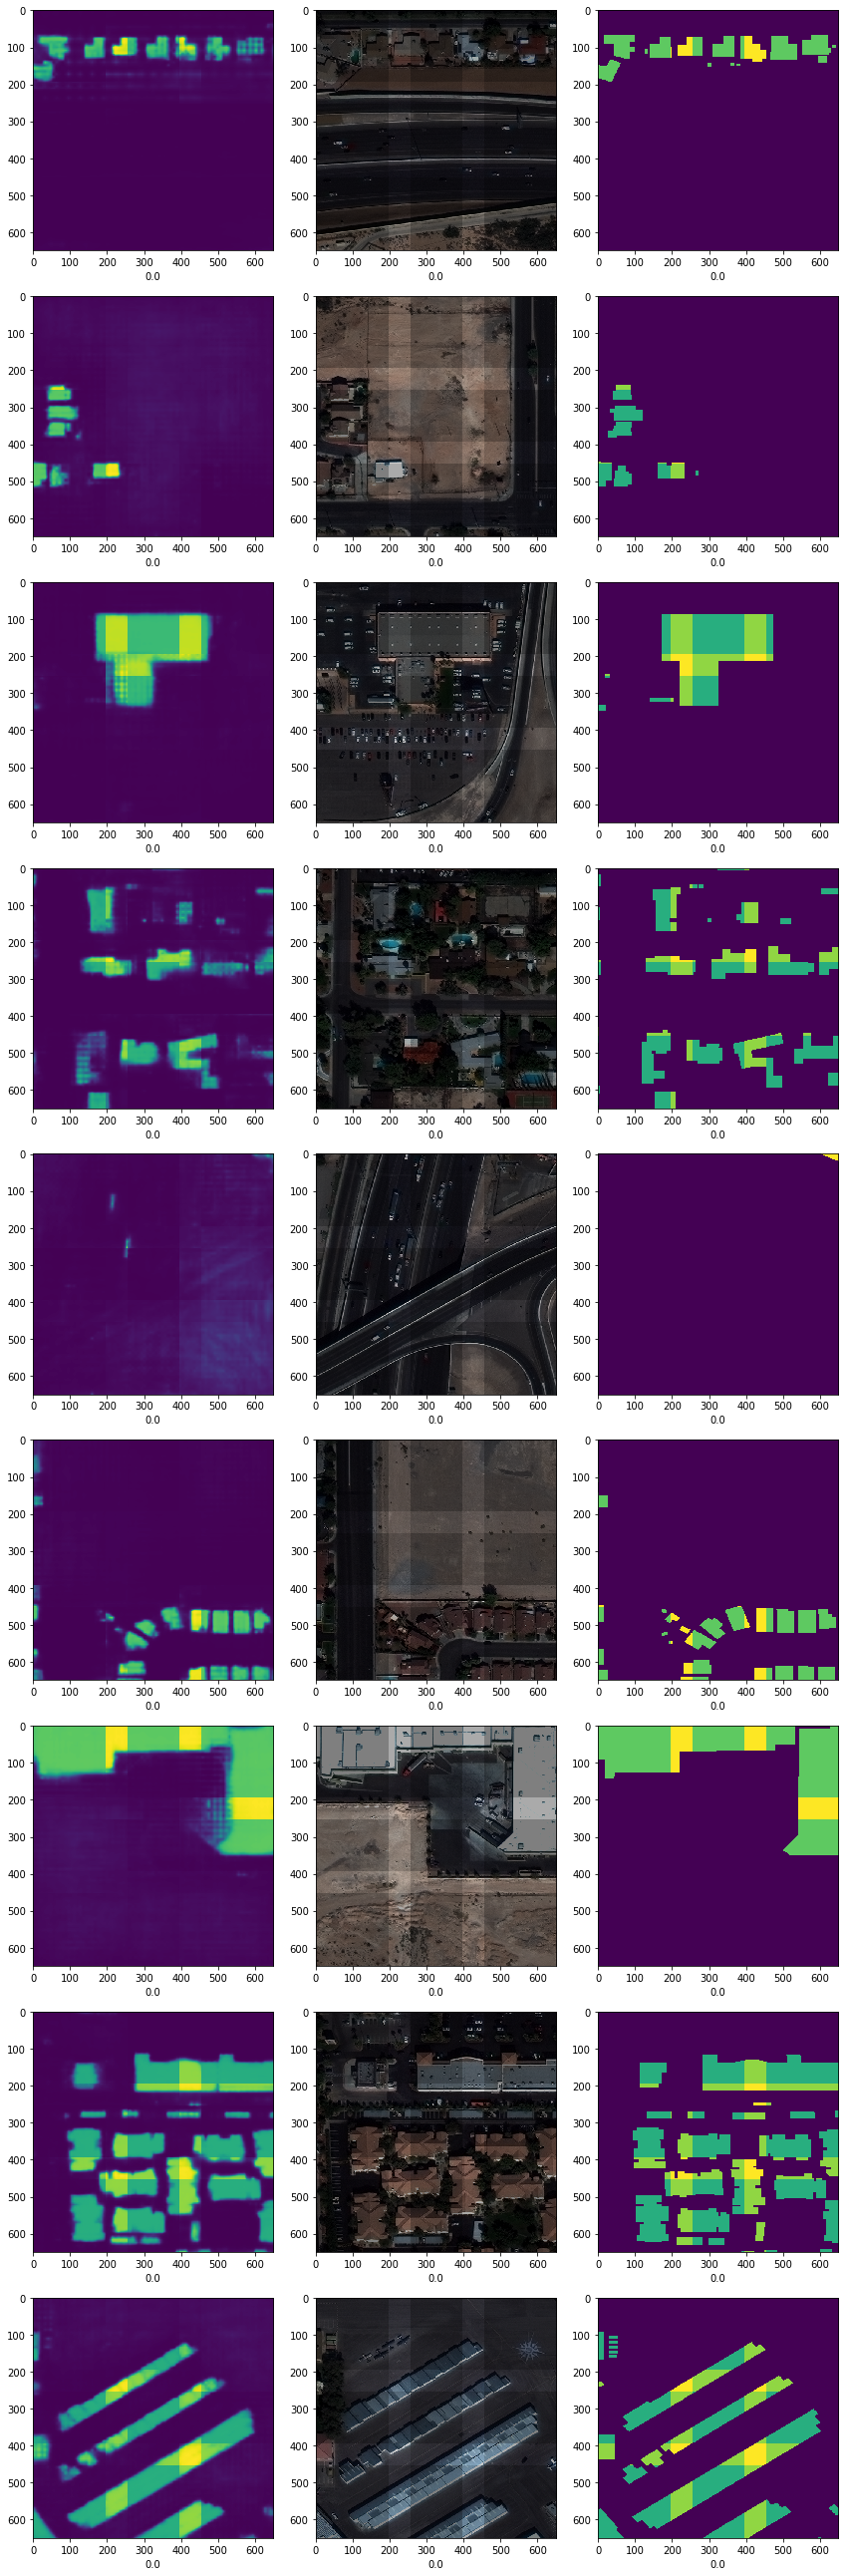

In [14]:
idx = 89
data_im = zip(preds_big[idx:idx + 9], x_big[idx:idx + 9], y_big[idx:idx + 9])
plot_ims(data_im, figsize=4)

0.30455681681632996


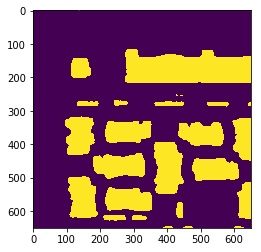

In [51]:
idx = 96
crfed = dense_crf((x_big[idx] * 255).astype('uint8'), (preds_big[idx]), 1, 7, 1)
plt.imshow(preds_big[idx] > 0.3)
print(jaccard_coef_cuda((V(preds_big[idx]) > 0.3).float(), V(y_big[idx])).data[0])

In [37]:
best_sxy1, best_sxy2, best_srgb = 0, 0, 0
best_jac = 0
# rows, cols = 3, 3
# sx1 = np.arange(1, , ).astype('uint8')
# eps = np.arange(1, 80, 80 / cols).astype('uint8')
# res = np.empty([rows, cols] + list(srcs.shape))
for sxy1 in np.arange(1, 10, 3):
    for sxy2 in np.arange(1, 10, 3):
        for srgb in np.arange(1, 10, 3):
            crfed = dense_crf((x_big[idx] * 255).astype('uint8'), (preds_big[idx]),
                             sxy1=sxy1, sxy2=sxy2, srgb=srgb)
            jac = jaccard_coef_cuda(V(crfed), V(y_big[idx])).data[0]
            if jac > best_jac:
                best_jac = jac
                best_sxy1, best_sxy2, best_srgb = sxy1, sxy2, srgb
                print(sxy1, sxy2, srgb, jac)
print(best_sxy1, best_sxy2, best_srgb, best_jac)

1 1 1 0.5475537180900574
1 4 1 0.5600182414054871
1 7 1 0.5678815245628357
1 7 1 0.5678815245628357


In [16]:
crfed = dense_crf((x_big[idx] * 255).astype('uint8'), (preds_big[idx]),
                             sxy1=1, sxy2=1, srgb=1)